The data we use in this project is from [PhysioNet 2016 Challenge](https://physionet.org/content/challenge-2016/1.0.0/)

# Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 
import librosa
import librosa.display
import IPython.display as ipd

import skimage.io
import wave


import tensorflow as tf
import tensorflow_io as tfio

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import lightgbm as lgb
import xgboost as xgb
from imblearn.over_sampling import SMOTE, ADASYN

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Functions We Use

In [126]:
def print_results(model, X_train, y_train,X_test, y_test):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
    
    ax1 = axes[0]
    plot_confusion_matrix(model, X_test, y_test, 
                          display_labels=le.classes_,
                          cmap=plt.cm.Blues, ax = ax1)
    
    ax1.set_title("Confusion Matrix for Test Set")
    
    ax2 = axes[1]
    plot_confusion_matrix(model, X_train, y_train, 
                          display_labels=le.classes_,
                          cmap=plt.cm.Blues, ax = ax2)
    
    
    ax2.set_title("Confusion Matrix for Train Set")
    
    
    
    ### Presenting Classification Report as a DataFrame
    
    train_class = classification_report(y_train, model.predict(X_train), output_dict = True)
    test_class  = classification_report(y_test, model.predict(X_test), output_dict = True)
    
    train_df = pd.DataFrame(train_class)
    test_df  = pd.DataFrame(test_class)
    
    train_df["data"] = "TRAIN"
    test_df["data"] = "TEST"
    

    report = pd.concat([test_df, train_df], axis = 0)
    report.rename(columns = {"1": f"{list(le.inverse_transform([1]))[0]}",
                             "0": f"{list(le.inverse_transform([0]))[0]}"}, inplace = True)
    report["index"] = list(report.index)

    report.set_index(["data", "index"], inplace = True)
    
    for item in list(report.columns):
        report[item] = report[item].apply(lambda x: np.round(x,2))
        
        
    score = {}
    score["test_recall"]  = report["abnormal"]["TEST"]["recall"]
    score["train_recall"] = report["abnormal"]["TRAIN"]["recall"]
    
    score["test_accuracy"]  = report["accuracy"]["TEST"]["recall"]
    score["train_accuracy"] = report["accuracy"]["TRAIN"]["recall"]
    
    return report, score

# Train Set

In [3]:
training = {"a": "training-a", "b": "training-b",
            "c": "training-c", "d": "training-d",
            "e": "training-e", "f": "training-f"}
df_ref = {}

def file_path(audio_name):
    return f"../train_test_original/training-{audio_name[0]}/{audio_name}.wav"

for key in training:
    
    path = "../train_test_original/"+training[key]+"/REFERENCE-SQI.csv"
    df_ref[key] = pd.read_csv(path, header=None).rename(columns = {
       0:"name", 1:"num_1", 2:"num_2"})
    df_ref[key]["path"] = df_ref[key]["name"].apply(lambda x: file_path(x))

In [4]:
training = {"a": "training-a", "b": "training-b",
            "c": "training-c", "d": "training-d",
            "e": "training-e", "f": "training-f"}

records = {}
df_records = {}


for key in training:
    
    all_rec = "../train_test_original/"+training[key]+"/RECORDS"
    normal  = "../train_test_original/"+training[key]+"/RECORDS-normal"
    abnormal= "../train_test_original/"+training[key]+"/RECORDS-abnormal"

    all_recs = {}
    normals = {}
    abnormals = {}

    with open(all_rec, "r") as rec:
        all_rec = rec.readlines()
        for line in all_rec:
            all_recs[line[:-1]] = 0


    with open(normal, "r") as n:
        n_recs = n.readlines()
        for line in n_recs:
            normals[line[:-1]] = "normal"
        
    with open(abnormal, "r") as ab:
        ab_recs = ab.readlines()
        for line in ab_recs:
            abnormals[line[:-1]] = "abnormal"     
        
        

    for item in all_recs:
        if item in list(normals.keys()):
            all_recs[item] = normals[item]
        else:
            all_recs[item] = abnormals[item]
            
    records[key] = all_recs
    df_records[key] = pd.DataFrame(list(records[key].items()),
                            columns = ['Audio','target'])

In [5]:
sum = 0
for item in df_records:
    print(item, len(df_records[item]))
    sum += len(df_records[item])
    
print("\n",sum)   

a 409
b 490
c 31
d 55
e 2141
f 114

 3240


In [6]:
df_train = pd.DataFrame()
all_records = pd.DataFrame()
all_ref = pd.DataFrame()

all_records = df_records["a"]
all_ref     = df_ref["a"]

for item in ["b", "c", "d", "e", "f"]:
    all_records = pd.concat([all_records, df_records[item]], axis = 0)
    all_ref     = pd.concat([all_ref, df_ref[item]], axis = 0)

df_train = pd.concat([all_ref, all_records], axis = 1)
df_train.drop(columns = ["num_1","Audio"], inplace = True, axis = 1)
df_train = df_train.sample(frac = 1)


df_train.to_csv('df_train.csv')

In [7]:
df_train.head()

,name,num_2,path,target
34,a0035,1,../train_test_original/training-a/a0035.wav,normal
1819,e01820,1,../train_test_original/training-e/e01820.wav,normal
1151,e01152,1,../train_test_original/training-e/e01152.wav,normal
66,b0067,1,../train_test_original/training-b/b0067.wav,normal
235,e00236,1,../train_test_original/training-e/e00236.wav,normal


In [8]:
df_train.duplicated().sum()

0

In [9]:
df_train.isna().sum()

name      0
num_2     0
path      0
target    0
dtype: int64

In [10]:
df_train.target.value_counts()

normal      2575
abnormal     665
Name: target, dtype: int64

# Test Set

In [41]:
df_test = {}

path = "../train_test_original/validation/REFERENCE.csv"
df_test = pd.read_csv(path, header=None).rename(columns = {0:"Name",
                                                               1: "target"})

df_test.target = df_test.target.map({1: "abnormal", -1: "normal"})
df_test = df_test.sample(frac = 1)
df_test.to_csv('df_test.csv')


In [42]:
df_test.head()

,Name,target
113,b0034,normal
158,b0140,abnormal
86,b0007,normal
19,a0020,abnormal
94,b0015,normal


In [43]:
df_test.target.value_counts(normalize = True)

abnormal    0.501661
normal      0.498339
Name: target, dtype: float64

# Converting Audio to Tensors

This code is from [here](https://github.com/nicknochnack/DeepAudioClassification/blob/main/AudioClassification.ipynb) 


In [11]:
def get_wave(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)  ## The output needs to be decoded by using the next line
    ## Next line gives a numerical values of an audio file and the output needs to be reshaped
    # Decode wav (tensors by channels) ## Desired Channel = 1 means not sterio type
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) 
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

(119192,)


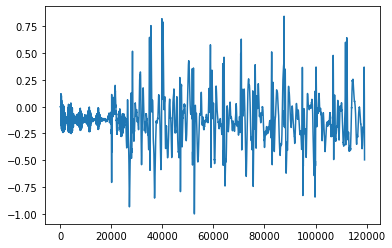

In [12]:
example_path = df_train["path"].iloc[100]
example_wav = get_wave(example_path)
print(example_wav.shape)
plt.plot(example_wav)
plt.show();

Because the tensors will have different length, we will need to pad them with 0's. To do that we use the following function, this function is adopted from [here](https://www.tensorflow.org/tutorials/audio/simple_audio)

In [13]:
def zero_padding(filename, input_len):
    waveform = get_wave(filename)
    waveform = waveform[:input_len]
    zero_padding = tf.zeros([input_len] - tf.shape(waveform),
      dtype=tf.float32)
    
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    
    return equal_length
    

Getting the length of each audio file and add it to the df_train

In [14]:
# df_train["audio_length"] = df_train["path"].apply(lambda x: len(get_wave(x)))

In [15]:
# df_train["audio_length"].plot(kind = "hist");

In [16]:
# print("max: ", df_train["audio_length"].max())
# print("min: ", df_train["audio_length"].min())
# print("mean: ", df_train["audio_length"].mean())
# print("median: ", df_train["audio_length"].median())

# Creating some numerical data for Some Basic Models

In [17]:
length_lr = 5*10**4
delta = 5000

data_ML = df_train.copy()

print(len(df_train))
print(len(data_ML))
data_ML["values"] = data_ML["path"].apply(lambda x: 
                                          get_wave(x)[length_lr-delta:length_lr].numpy())
print("Padding Done")

3240
3240
Padding Done


In [18]:
df_lr = pd.DataFrame(columns = list(range(0, delta)), 
                     index = data_ML.index)
print("DONE!")

DONE!


In [19]:
for i in range(0,len(data_ML)):
    df_lr.iloc[i] = pd.DataFrame(data_ML["values"].iloc[i]).transpose()
    

df_lr["target"] = data_ML["target"] 

print("DONE!")


DONE!


# Train-Test Split

In [20]:
le = LabelEncoder()

y = df_lr[["target"]]
X = df_lr.drop(columns = ["target"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
print("DONE!")

DONE!


53
0.9520337112909985


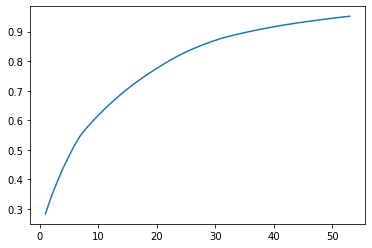

In [44]:
l = []
pca_n = list(range(1, 60))
for i in pca_n:
    pca = PCA(n_components = i)
    pca.fit_transform(X_train.values)
    l.append(list(pca.explained_variance_ratio_.cumsum())[-1])
    if l[-1] >= 0.95:
        n = i
        print(i)
        print(l[-1])
        break
    
plt.plot(range(1, n+1), l);

## Train-Test PCA

In [51]:
pca_95 = PCA(n_components = n)
X_train_pca = pca_95.fit_transform(X_train.values)
X_test_pca  = pca_95.transform(X_test.values)

## Train-Test SMOTE

In [56]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## Train-Test PCA-SMOTE

In [57]:
pca_95 = PCA(n_components = n)
X_train_smote_pca = pca_95.fit_transform(X_train_smote.values)
X_test_pca  = pca_95.transform(X_test.values)

# Modeling

In [127]:
model_scores = {}

## Logistic Regression

### Train-Test Original 

Fitting Done!


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.22     0.81      0.52       0.52          0.69
      recall         0.53     0.52      0.52       0.53          0.52
      f1-score       0.31     0.63      0.52       0.47          0.57
      support      133.00   515.00      0.52     648.00        648.00
TRAIN precision      0.35     0.90      0.66       0.62          0.79
      recall         0.73     0.64      0.66       0.69          0.66
      f1-score       0.47     0.75      0.66       0.61          0.69
      support      532.00  2060.00      0.66    2592.00       2592.00

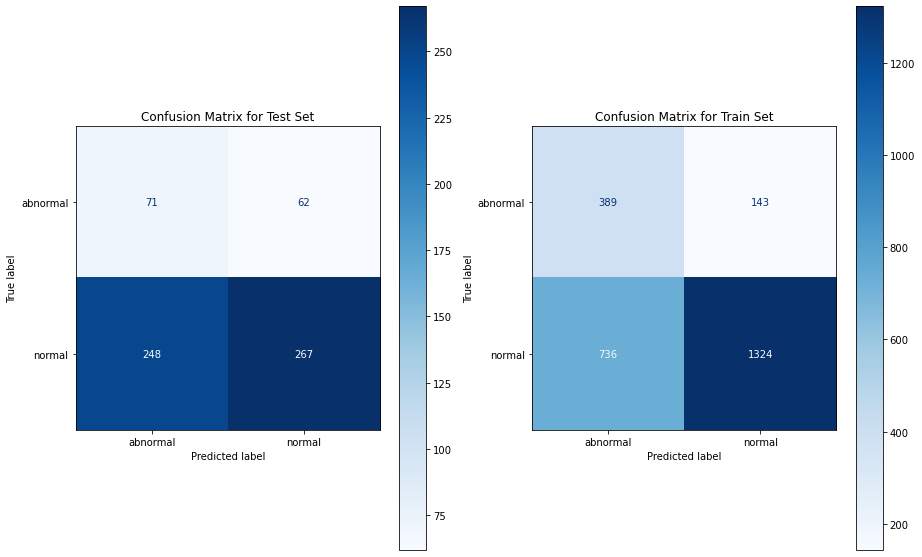

In [128]:
lr = LogisticRegression(solver='liblinear',random_state=42, class_weight="balanced")
lr.fit(X_train, y_train)
print("Fitting Done!")
report, model_scores["lr"] = print_results(lr, X_train, y_train,
                                           X_test, y_test)
report

### Train-Test PCA 


Fitting Done!


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.23     0.81      0.54       0.52          0.69
      recall         0.52     0.54      0.54       0.53          0.54
      f1-score       0.31     0.65      0.54       0.48          0.58
      support      133.00   515.00      0.54     648.00        648.00
TRAIN precision      0.28     0.88      0.57       0.58          0.76
      recall         0.72     0.53      0.57       0.63          0.57
      f1-score       0.41     0.66      0.57       0.53          0.61
      support      532.00  2060.00      0.57    2592.00       2592.00

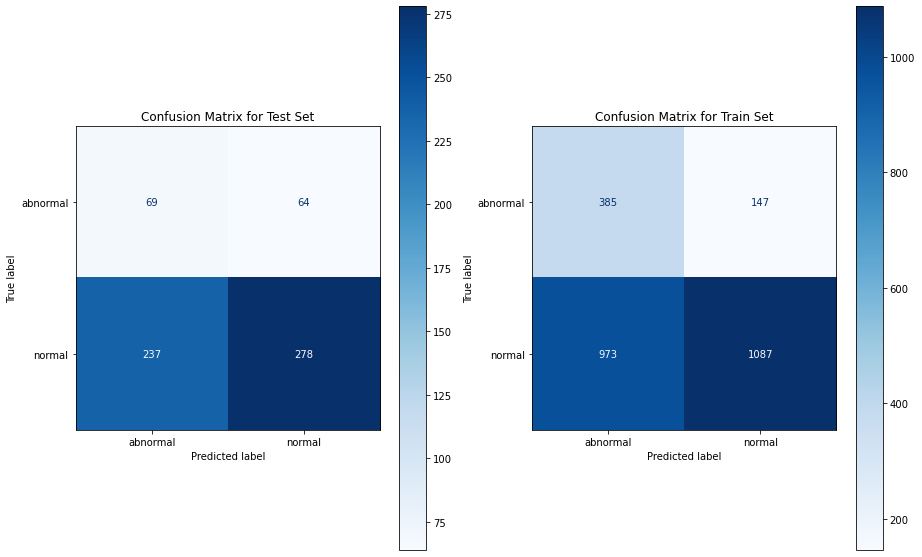

In [129]:
lr_pca = LogisticRegression(solver='liblinear',random_state=42, class_weight="balanced")
lr_pca.fit(X_train_pca, y_train)
print("Fitting Done!")
report, model_scores["lr_pca"] = print_results(lr_pca, X_train_pca, 
                                          y_train, X_test_pca, y_test)
report

### Train-Test SMOTE

Fitting Done!


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.23     0.82      0.51       0.53          0.70
      recall         0.59     0.50      0.51       0.54          0.51
      f1-score       0.33     0.62      0.51       0.47          0.56
      support      133.00   515.00      0.51     648.00        648.00
TRAIN precision      0.69     0.78      0.72       0.73          0.73
      recall         0.82     0.62      0.72       0.72          0.72
      f1-score       0.75     0.69      0.72       0.72          0.72
      support     2060.00  2060.00      0.72    4120.00       4120.00

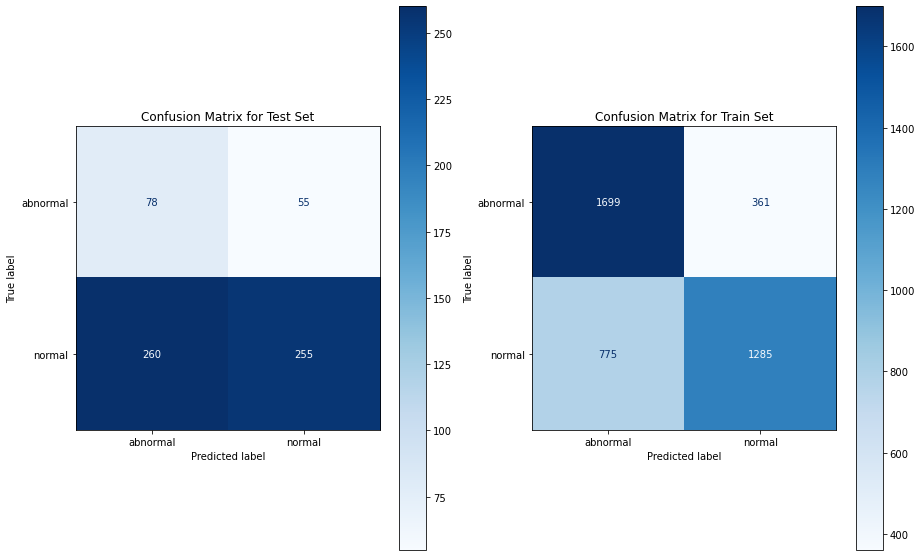

In [130]:
lr_smote = LogisticRegression(solver='liblinear',random_state=42)
lr_smote.fit(X_train_smote, y_train_smote)
print("Fitting Done!")

report, model_scores["lr_smote"] = print_results(lr_smote, X_train_smote, 
                                                y_train_smote, X_test, y_test)

report

### Train-Test SMOTE PCA 

Fitting Done!


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.24     0.83      0.51       0.53          0.71
      recall         0.62     0.48      0.51       0.55          0.51
      f1-score       0.34     0.61      0.51       0.47          0.55
      support      133.00   515.00      0.51     648.00        648.00
TRAIN precision      0.61     0.70      0.64       0.66          0.66
      recall         0.78     0.51      0.64       0.64          0.64
      f1-score       0.69     0.59      0.64       0.64          0.64
      support     2060.00  2060.00      0.64    4120.00       4120.00

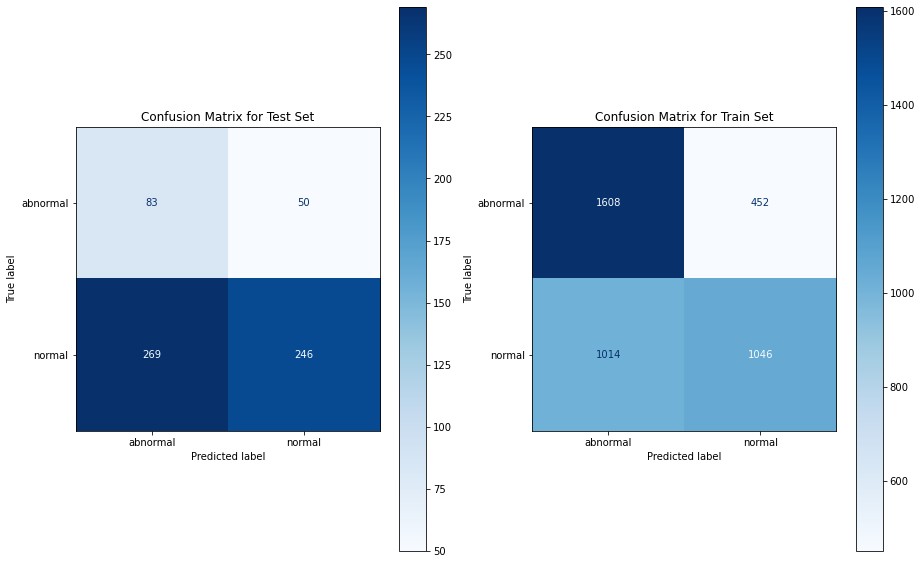

In [131]:
lr_smote_pca = LogisticRegression(solver='liblinear',random_state=42)
lr_smote_pca.fit(X_train_smote_pca, y_train_smote)
print("Fitting Done!")

report, model_scores["lr_smote_pca"] = print_results(lr_smote_pca, 
                                                      X_train_smote_pca, 
                                                      y_train_smote,
                                                      X_test_pca, y_test)

report

## Decision Tree

### Train-Test Original 

Fitting Tree


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.30     0.82       0.7       0.56          0.72
      recall         0.35     0.79       0.7       0.57          0.70
      f1-score       0.32     0.81       0.7       0.56          0.71
      support      133.00   515.00       0.7     648.00        648.00
TRAIN precision      1.00     1.00       1.0       1.00          1.00
      recall         1.00     1.00       1.0       1.00          1.00
      f1-score       1.00     1.00       1.0       1.00          1.00
      support      532.00  2060.00       1.0    2592.00       2592.00

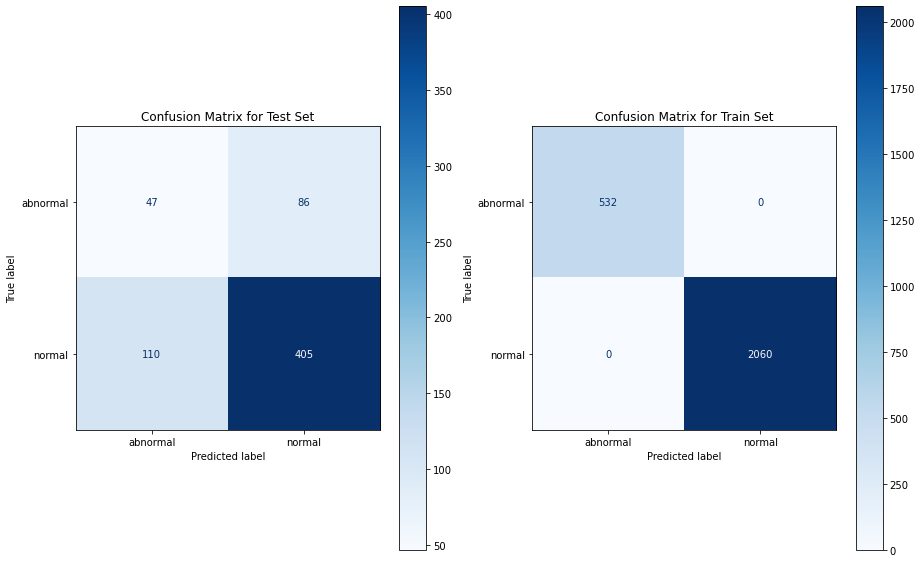

In [132]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

print("Fitting Tree")
report, model_scores["tree"] = print_results(tree, X_train, y_train, 
                                              X_test, y_test)

report

### Train-Test PCA 

Fitting Tree


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.29     0.80      0.76       0.55          0.70
      recall         0.11     0.93      0.76       0.52          0.76
      f1-score       0.16     0.86      0.76       0.51          0.72
      support      133.00   515.00      0.76     648.00        648.00
TRAIN precision      1.00     1.00      1.00       1.00          1.00
      recall         1.00     1.00      1.00       1.00          1.00
      f1-score       1.00     1.00      1.00       1.00          1.00
      support      532.00  2060.00      1.00    2592.00       2592.00

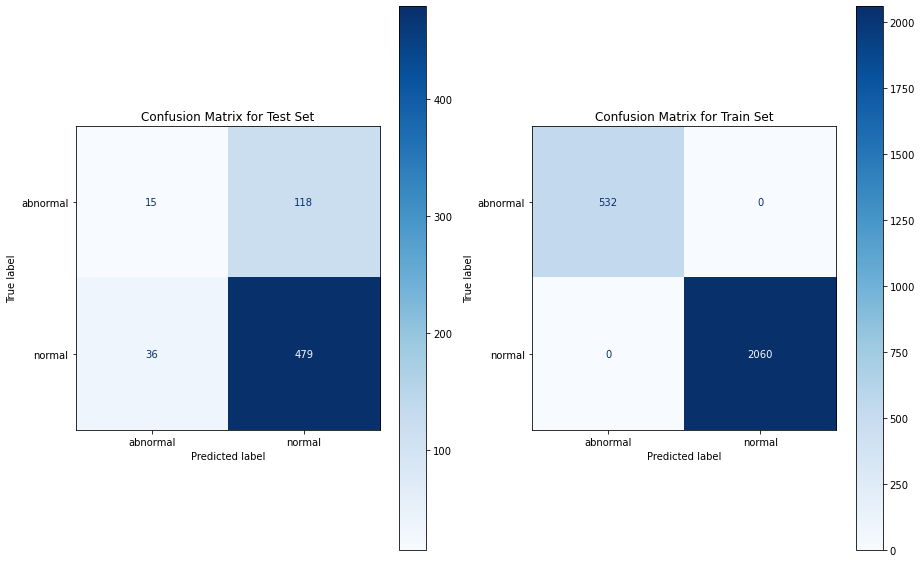

In [133]:
tree_pca = DecisionTreeClassifier()
tree_pca.fit(X_train_pca, y_train)

print("Fitting Tree")
report, model_scores["tree_pca"] = print_results(tree_pca, X_train_pca,
                                              y_train, X_test_pca, y_test)

report

### Train-Test SMOTE

Fitting Done!


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.25     0.82      0.62       0.53          0.70
      recall         0.43     0.66      0.62       0.55          0.62
      f1-score       0.31     0.73      0.62       0.52          0.65
      support      133.00   515.00      0.62     648.00        648.00
TRAIN precision      1.00     1.00      1.00       1.00          1.00
      recall         1.00     1.00      1.00       1.00          1.00
      f1-score       1.00     1.00      1.00       1.00          1.00
      support     2060.00  2060.00      1.00    4120.00       4120.00

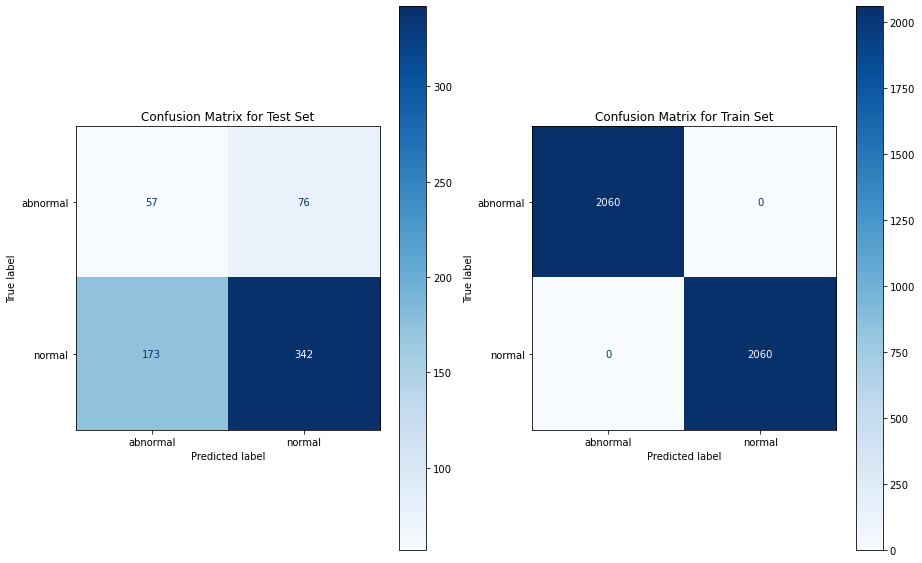

In [134]:
tree_smote = DecisionTreeClassifier()
tree_smote.fit(X_train_smote, y_train_smote)
print("Fitting Done!")
report, model_scores["tree_smote"] = print_results(tree_smote, X_train_smote,
                                                    y_train_smote, X_test,
                                                    y_test)
report

### Train-Test SMOTE PCA

Fitting Done!


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.37     0.86      0.72       0.62          0.76
      recall         0.52     0.77      0.72       0.64          0.72
      f1-score       0.43     0.81      0.72       0.62          0.74
      support      133.00   515.00      0.72     648.00        648.00
TRAIN precision      1.00     1.00      1.00       1.00          1.00
      recall         1.00     1.00      1.00       1.00          1.00
      f1-score       1.00     1.00      1.00       1.00          1.00
      support     2060.00  2060.00      1.00    4120.00       4120.00

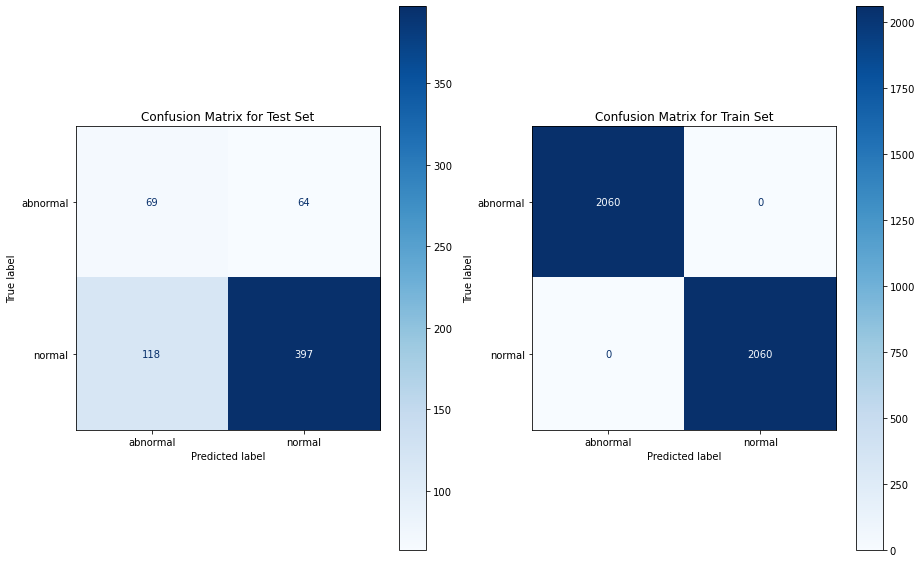

In [135]:
tree_smote_pca = DecisionTreeClassifier()
tree_smote_pca.fit(X_train_smote_pca, y_train_smote)
print("Fitting Done!")
report, model_scores["tree_smote_pca"] = print_results(tree_smote_pca, 
                                                        X_train_smote_pca,
                                                        y_train_smote, 
                                                        X_test_pca, y_test)

report

## Random Forest

### Train-Test Original

Fitting Tree


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.34     0.85      0.69       0.60          0.75
      recall         0.51     0.74      0.69       0.63          0.69
      f1-score       0.41     0.79      0.69       0.60          0.71
      support      133.00   515.00      0.69     648.00        648.00
TRAIN precision      0.56     0.95      0.83       0.76          0.87
      recall         0.83     0.83      0.83       0.83          0.83
      f1-score       0.67     0.89      0.83       0.78          0.84
      support      532.00  2060.00      0.83    2592.00       2592.00

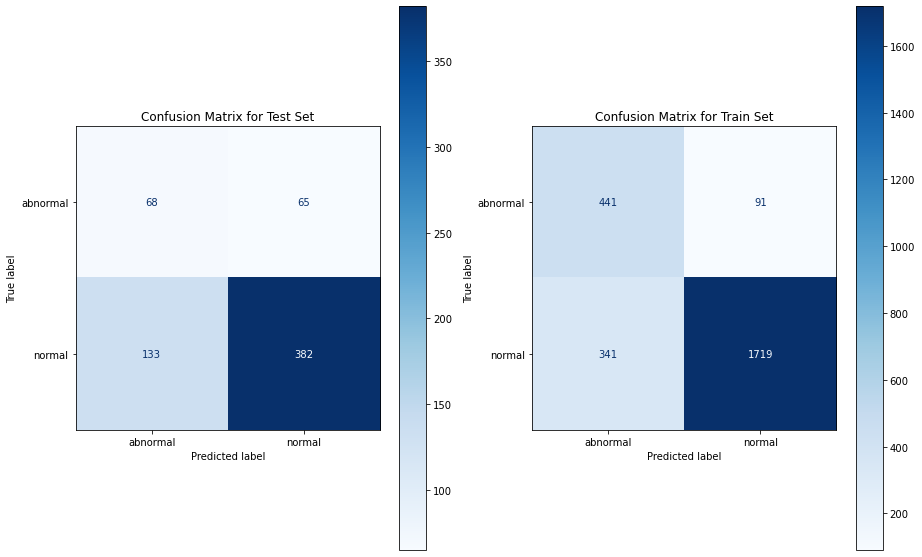

In [136]:
forest = RandomForestClassifier(criterion="entropy", 
                                n_estimators= 10,
                                max_depth = 5, 
                                bootstrap = True,
                                class_weight = "balanced",
                                random_state = 42)

forest.fit(X_train, y_train)

print("Fitting Tree")
report, model_scores["forest"] = print_results(forest, X_train, y_train, 
                                               X_test, y_test)

report

### Train-Test PCA

Fitting Tree


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.34     0.81      0.76       0.58          0.71
      recall         0.17     0.92      0.76       0.54          0.76
      f1-score       0.22     0.86      0.76       0.54          0.73
      support      133.00   515.00      0.76     648.00        648.00
TRAIN precision      0.49     0.94      0.79       0.72          0.85
      recall         0.81     0.78      0.79       0.80          0.79
      f1-score       0.61     0.86      0.79       0.73          0.81
      support      532.00  2060.00      0.79    2592.00       2592.00

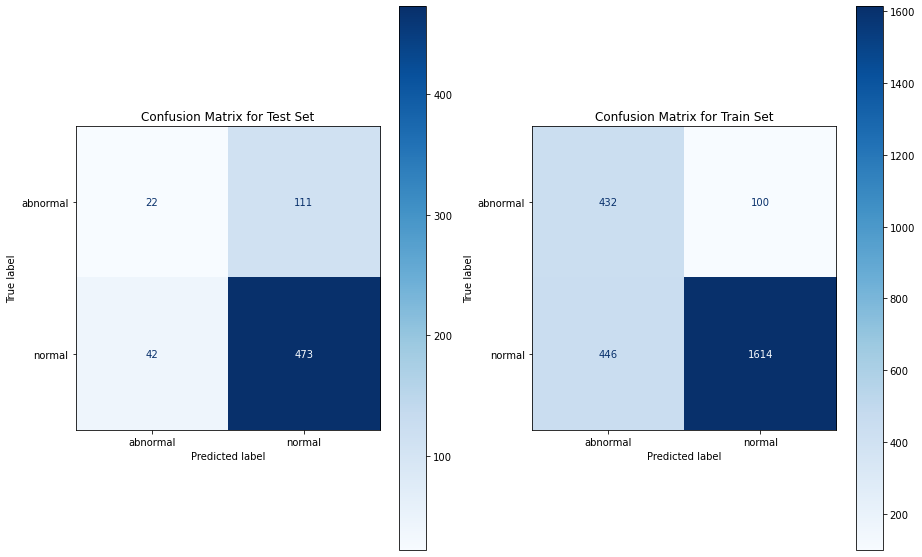

In [137]:
forest_pca = RandomForestClassifier(criterion="entropy", 
                                n_estimators= 10,
                                max_depth = 5, 
                                bootstrap = True,
                                class_weight = "balanced",
                                random_state = 42)

forest_pca.fit(X_train_pca, y_train)

print("Fitting Tree")
report, model_scores["forest_pca"] = print_results(forest_pca, X_train_pca,
                                               y_train, X_test_pca, y_test)

report

### Train-Test SMOTE


Fitting Tree


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.32     0.87      0.65       0.60          0.76
      recall         0.62     0.66      0.65       0.64          0.65
      f1-score       0.43     0.75      0.65       0.59          0.69
      support      133.00   515.00      0.65     648.00        648.00
TRAIN precision      0.80     0.86      0.83       0.83          0.83
      recall         0.88     0.78      0.83       0.83          0.83
      f1-score       0.84     0.82      0.83       0.83          0.83
      support     2060.00  2060.00      0.83    4120.00       4120.00

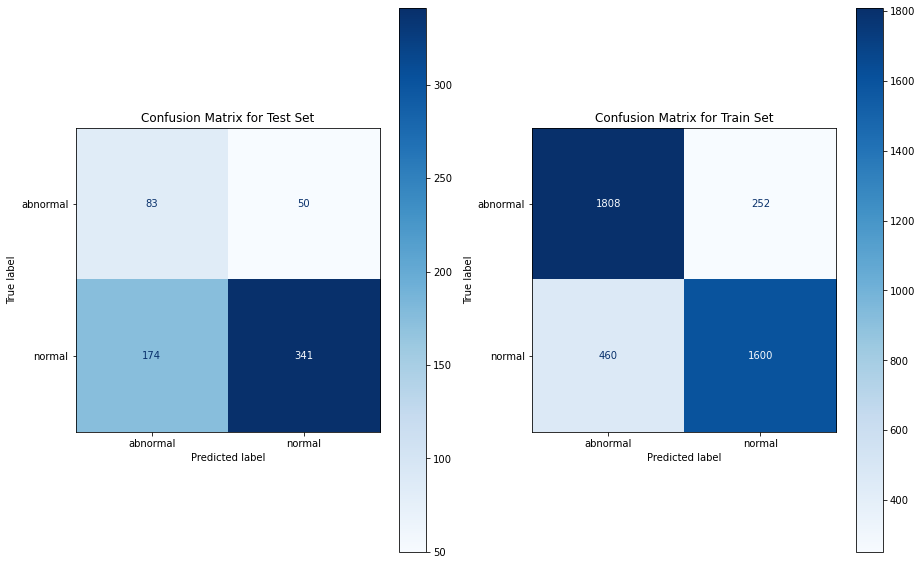

In [138]:
forest_smote = RandomForestClassifier(criterion="entropy", 
                                n_estimators= 10,
                                max_depth = 5, 
                                bootstrap = True,
#                                 class_weight = "balanced",
                                random_state = 42)

forest_smote.fit(X_train_smote, y_train_smote)

print("Fitting Tree")
report, model_scores["forest_smote"] = print_results(forest_smote, X_train_smote, 
                                               y_train_smote, X_test, y_test)

report

### Train-Test SMOTE PCA

Fitting Tree


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.34     0.87      0.67       0.60          0.76
      recall         0.61     0.69      0.67       0.65          0.67
      f1-score       0.43     0.77      0.67       0.60          0.70
      support      133.00   515.00      0.67     648.00        648.00
TRAIN precision      0.77     0.81      0.79       0.79          0.79
      recall         0.83     0.76      0.79       0.79          0.79
      f1-score       0.80     0.78      0.79       0.79          0.79
      support     2060.00  2060.00      0.79    4120.00       4120.00

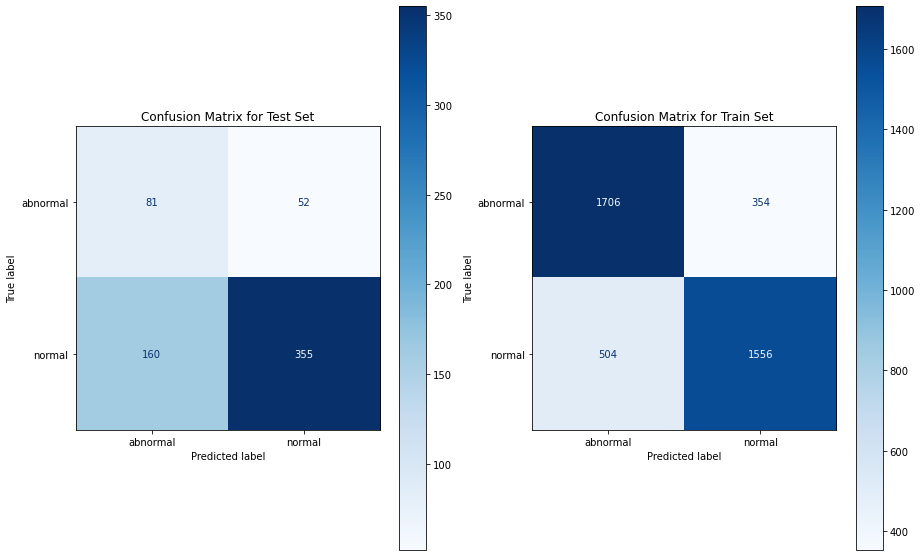

In [139]:
forest_smote_pca = RandomForestClassifier(criterion="entropy", 
                                n_estimators= 10,
                                max_depth = 5, 
                                bootstrap = True,
#                                 class_weight = "balanced",
                                random_state = 42)

forest_smote_pca.fit(X_train_smote_pca, y_train_smote)

print("Fitting Tree")
report, model_scores["forest_smote_pca"] = print_results(forest_smote_pca, 
                                               X_train_smote_pca,
                                               y_train_smote, X_test_pca,
                                               y_test)

report

## XGBoost

### Train-Test Original

Fitting Done


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.50     0.82      0.79       0.66          0.75
      recall         0.16     0.96      0.79       0.56          0.79
      f1-score       0.24     0.88      0.79       0.56          0.75
      support      133.00   515.00      0.79     648.00        648.00
TRAIN precision      0.99     0.94      0.95       0.96          0.95
      recall         0.75     1.00      0.95       0.87          0.95
      f1-score       0.85     0.97      0.95       0.91          0.94
      support      532.00  2060.00      0.95    2592.00       2592.00

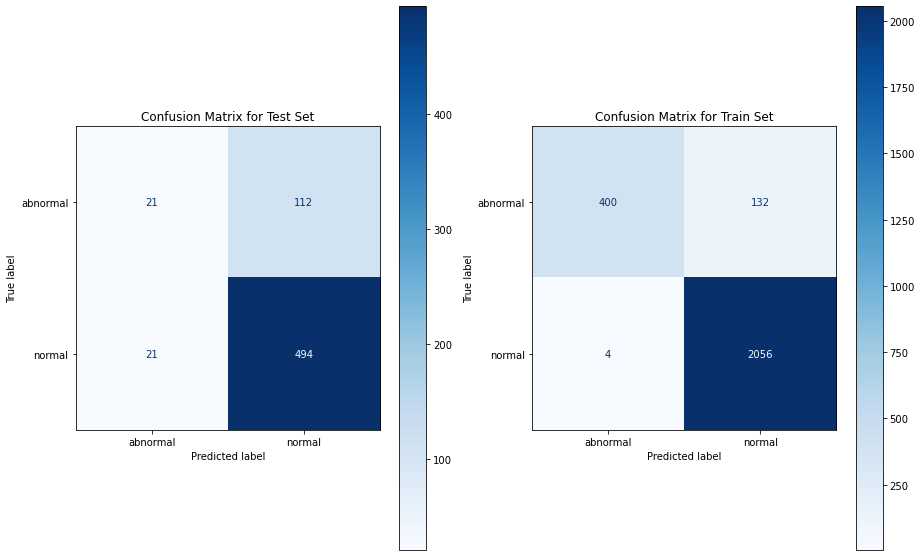

In [140]:
xg = xgb.XGBClassifier(max_depth = 10, n_estimators= 15, seed=42,
                        alpha = 10, 
                        objective = 'binary:logistic', 
                        eval_metric = "auc")

xg.fit(X_train.values, y_train)

print("Fitting Done")
report, model_scores["XGBoost"] = print_results(xg, X_train.values,
                                                         y_train, X_test.values,
                                                         y_test)

report

### Train-Test PCA

Fitting Done


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.67     0.81      0.80       0.74          0.78
      recall         0.09     0.99      0.80       0.54          0.80
      f1-score       0.16     0.89      0.80       0.52          0.74
      support      133.00   515.00      0.80     648.00        648.00
TRAIN precision      0.96     0.92      0.92       0.94          0.92
      recall         0.64     0.99      0.92       0.82          0.92
      f1-score       0.77     0.95      0.92       0.86          0.92
      support      532.00  2060.00      0.92    2592.00       2592.00

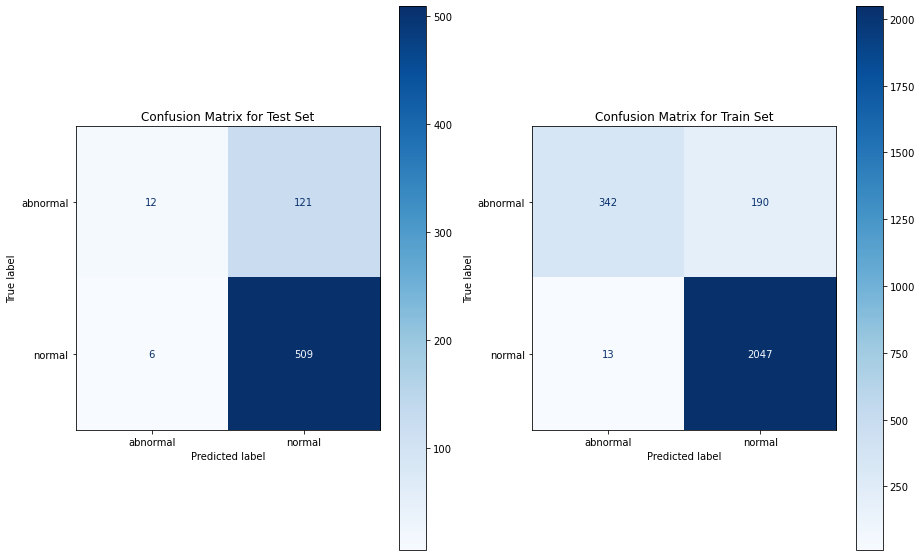

In [141]:
xg_pca = xgb.XGBClassifier(max_depth = 10, n_estimators= 15, seed=42,
                        alpha = 10, 
                        objective = 'binary:logistic', 
                        eval_metric = "auc")

xg_pca.fit(X_train_pca, y_train)

print("Fitting Done")
report, model_scores["XGBoost_pca"] = print_results(xg_pca, X_train_pca,
                                                y_train, X_test_pca, y_test)

report

### Train-Test SMOTE

Fitting Done


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.40     0.87      0.74       0.64          0.77
      recall         0.55     0.79      0.74       0.67          0.74
      f1-score       0.46     0.83      0.74       0.65          0.75
      support      133.00   515.00      0.74     648.00        648.00
TRAIN precision      0.98     0.99      0.99       0.99          0.99
      recall         0.99     0.98      0.99       0.99          0.99
      f1-score       0.99     0.99      0.99       0.99          0.99
      support     2060.00  2060.00      0.99    4120.00       4120.00

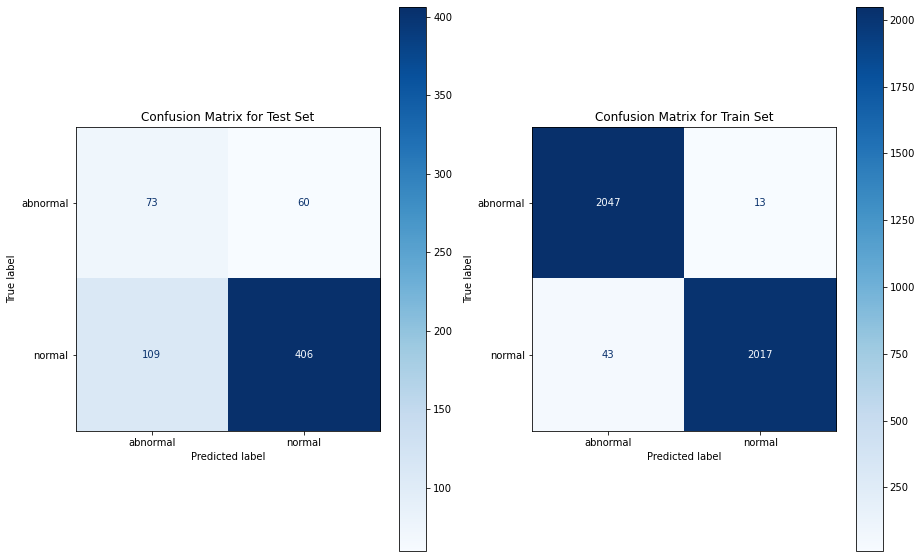

In [142]:
xg_smote = xgb.XGBClassifier(max_depth = 10, n_estimators= 15, seed=42,
                        alpha = 10, 
                        objective = 'binary:logistic', 
                        eval_metric = "auc")

xg_smote.fit(X_train_smote.values, y_train_smote)

print("Fitting Done")

report, model_scores["XGBoost_smote"] = print_results(xg_smote, 
                                                      X_train_smote.values, 
                                                      y_train_smote, 
                                                      X_test.values, y_test)

report

### Train-Test SMOTE PCA

Fitting Done


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.48     0.90      0.78       0.69          0.81
      recall         0.63     0.82      0.78       0.73          0.78
      f1-score       0.54     0.86      0.78       0.70          0.79
      support      133.00   515.00      0.78     648.00        648.00
TRAIN precision      0.94     0.98      0.96       0.96          0.96
      recall         0.98     0.93      0.96       0.96          0.96
      f1-score       0.96     0.95      0.96       0.96          0.96
      support     2060.00  2060.00      0.96    4120.00       4120.00

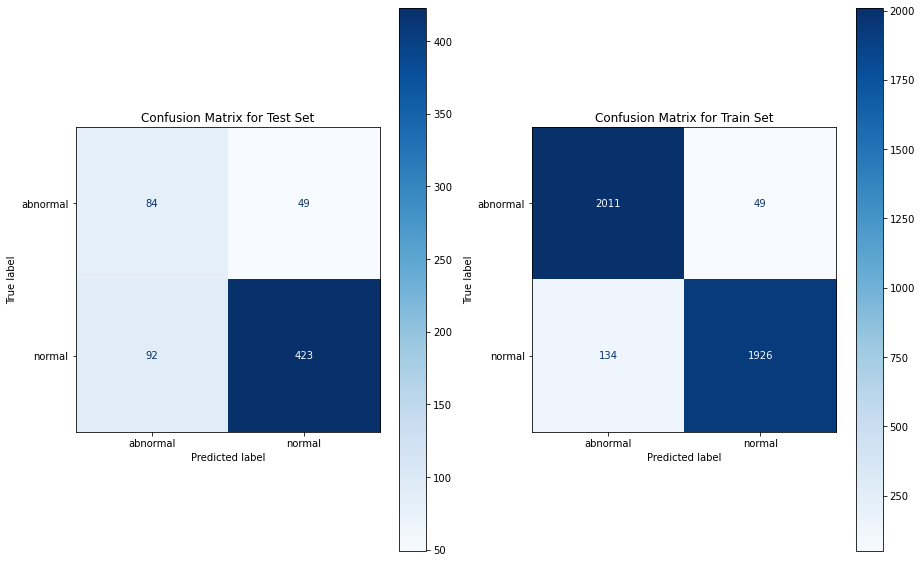

In [143]:
xg_smote_pca = xgb.XGBClassifier(max_depth = 10, n_estimators= 15, seed=42,
                        alpha = 10, 
                        objective = 'binary:logistic', 
                        eval_metric = "auc")

xg_smote_pca.fit(X_train_smote_pca, y_train_smote)

print("Fitting Done")
report, model_scores["XGBoost_smote_pca"] = print_results(xg_smote_pca, 
                                                          X_train_smote_pca, 
                                                          y_train_smote, 
                                                          X_test_pca, y_test)

report

## LightGBM


#### Params

In [144]:
params = {'num_boost_round':100,
        'learning_rate':0.02,
        'objective' : 'binary',
#         'feature_name' : list(X_train.columns),
        # 'cat_features': categorical,
        'depth':10,
        'eval_metric':'AUC',
        # 'verbose':200,
        'od_type':"Iter", # overfit detector
        'od_wait':500, # most recent best iteration to wait before stopping
        'random_seed': 42,
#         'class_weight' :  'balanced'
          }


### Train-Test Original

[LightGBM] [Warning] Unknown parameter: od_type
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: od_wait
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
Fitting Done


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.73     0.81      0.81       0.77          0.79
      recall         0.08     0.99      0.81       0.54          0.81
      f1-score       0.15     0.89      0.81       0.52          0.74
      support      133.00   515.00      0.81     648.00        648.00
TRAIN precision      0.99     0.93      0.94       0.96          0.95
      recall         0.73     1.00      0.94       0.86          0.94
      f1-score       0.84     0.97      0.94       0.90          0.94
      support      532.00  2060.00      0.94    2592.00       2592.00

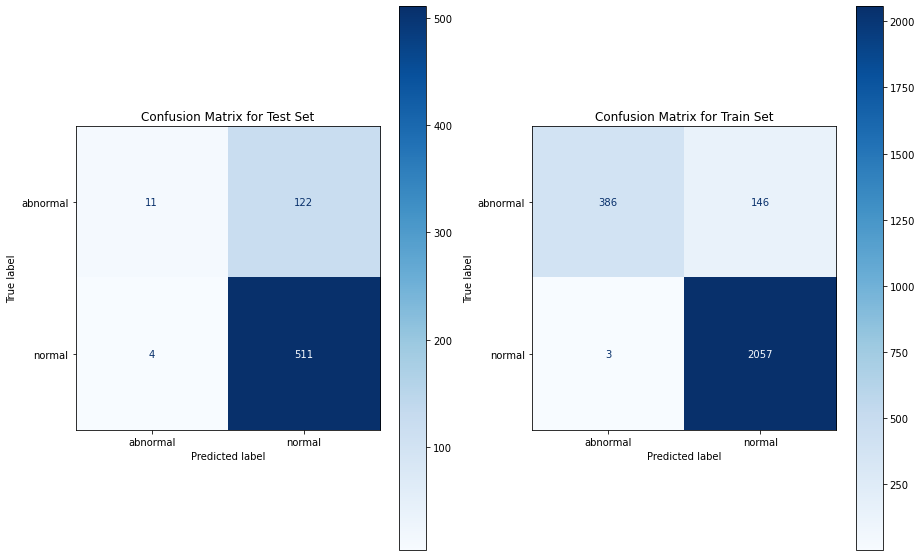

In [145]:
# num_boost_round=100
light = lgb.LGBMClassifier(**params)
light.fit(X_train.values, y_train)

print("Fitting Done")
report, model_scores["LightGBM"] =  print_results(light, X_train.values, 
                                                 y_train, X_test.values,
                                                 y_test)

report

### Train-Test PCA

[LightGBM] [Warning] Unknown parameter: od_type
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: od_wait
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
Fitting Done


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.71     0.81      0.80       0.76          0.79
      recall         0.08     0.99      0.80       0.53          0.80
      f1-score       0.14     0.89      0.80       0.51          0.73
      support      133.00   515.00      0.80     648.00        648.00
TRAIN precision      0.98     0.92      0.93       0.95          0.93
      recall         0.65     1.00      0.93       0.82          0.93
      f1-score       0.78     0.95      0.93       0.87          0.92
      support      532.00  2060.00      0.93    2592.00       2592.00

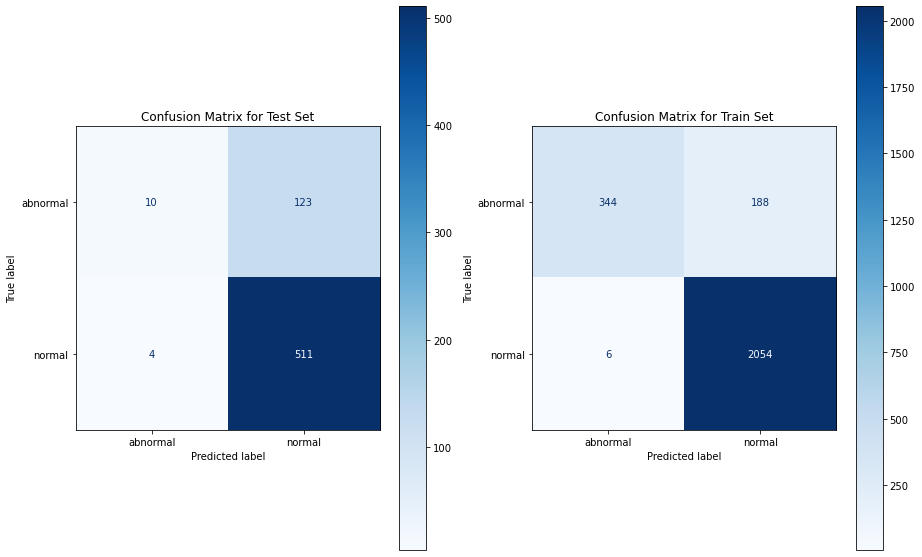

In [146]:
# num_boost_round=100
light_pca = lgb.LGBMClassifier(**params)
light_pca.fit(X_train_pca, y_train)

print("Fitting Done")

report, model_scores["LightGBM_pca"] =  print_results(light_pca, X_train_pca, 
                                                 y_train, X_test_pca,
                                                 y_test)

report

### Train-Test SMOTE

[LightGBM] [Warning] Unknown parameter: od_type
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: od_wait
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
Fitting Done


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.39     0.87      0.73       0.63          0.77
      recall         0.53     0.78      0.73       0.66          0.73
      f1-score       0.45     0.82      0.73       0.63          0.74
      support      133.00   515.00      0.73     648.00        648.00
TRAIN precision      0.95     0.97      0.96       0.96          0.96
      recall         0.97     0.95      0.96       0.96          0.96
      f1-score       0.96     0.96      0.96       0.96          0.96
      support     2060.00  2060.00      0.96    4120.00       4120.00

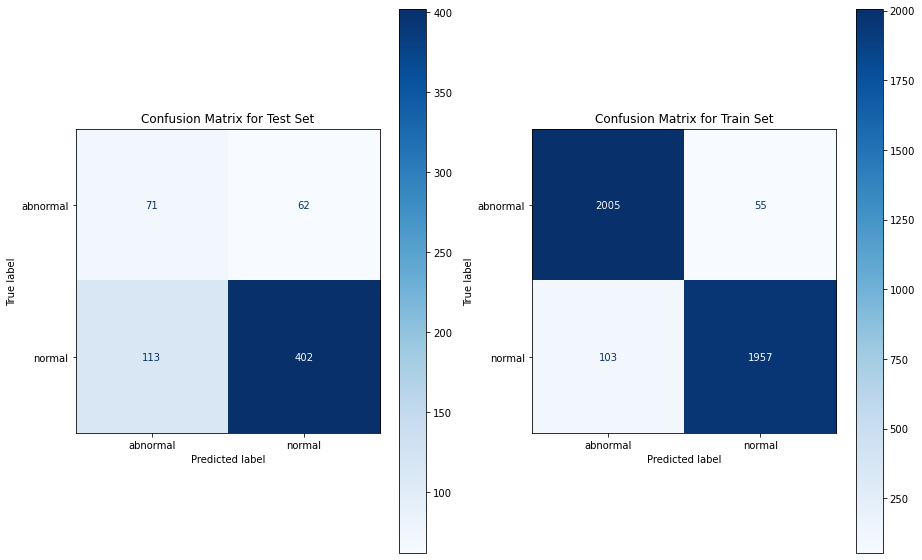

In [147]:
# num_boost_round=100
light_smote = lgb.LGBMClassifier(**params)
light_smote.fit(X_train_smote.values, y_train_smote)

print("Fitting Done")

report, model_scores["LightGBM_smote"] =  print_results(light_smote,
                                                        X_train_smote.values, 
                                                        y_train_smote, 
                                                        X_test.values,
                                                        y_test)

report

### Train-Test SMOTE PCA

[LightGBM] [Warning] Unknown parameter: od_type
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: od_wait
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
Fitting Done


abnormal   normal  accuracy  macro avg  weighted avg
data  index                                                          
TEST  precision      0.41     0.89      0.74       0.65          0.79
      recall         0.62     0.77      0.74       0.70          0.74
      f1-score       0.50     0.82      0.74       0.66          0.76
      support      133.00   515.00      0.74     648.00        648.00
TRAIN precision      0.90     0.94      0.92       0.92          0.92
      recall         0.95     0.89      0.92       0.92          0.92
      f1-score       0.92     0.92      0.92       0.92          0.92
      support     2060.00  2060.00      0.92    4120.00       4120.00

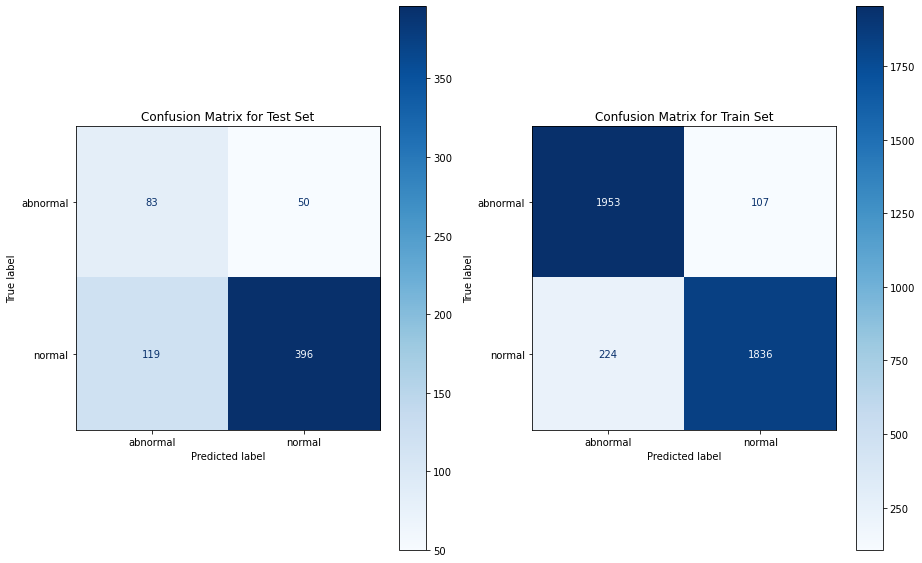

In [148]:
# num_boost_round=100
light_smote_pca = lgb.LGBMClassifier(**params)
light_smote_pca.fit(X_train_smote_pca, y_train_smote)

print("Fitting Done")

report, model_scores["LightGBM_smote_pca"] =  print_results(light_smote_pca,
                                                        X_train_smote_pca, 
                                                        y_train_smote, 
                                                        X_test_pca,
                                                        y_test)

report

# Modeling Results

In [149]:
print("ALL Done")

ALL Done


In [154]:
pd.DataFrame(model_scores).transpose()

,test_recall,train_recall,test_accuracy,train_accuracy
lr,0.53,0.73,0.52,0.66
lr_pca,0.52,0.72,0.54,0.57
lr_smote,0.59,0.82,0.51,0.72
lr_smote_pca,0.62,0.78,0.51,0.64
tree,0.35,1.00,0.70,1.00
tree_pca,0.11,1.00,0.76,1.00
tree_smote,0.43,1.00,0.62,1.00
tree_smote_pca,0.52,1.00,0.72,1.00
forest,0.51,0.83,0.69,0.83
forest_pca,0.17,0.81,0.76,0.79


In [156]:
df_train.target.value_counts(normalize = True)

normal      0.794753
abnormal    0.205247
Name: target, dtype: float64

# Getting Spectrogram of the Audio Files 

In [44]:
df_train["name"].iloc[0]

'a0001'

In [57]:
training = {"a": "training-a", "b": "training-b",
            "c": "training-c", "d": "training-d",
            "e": "training-e", "f": "training-f"}

### Example
audio_1 = df_train["name"].iloc[1000] 
audio_path = "../train_test_original/training-"+ audio_1[0] + "/"+ audio_1 + ".wav"
fig_path = "../spectrograms/"+  audio_1

SAMPLE_RATE = 3000
x, sr = librosa.load(audio_path, sr=SAMPLE_RATE)
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(82044,) 3000


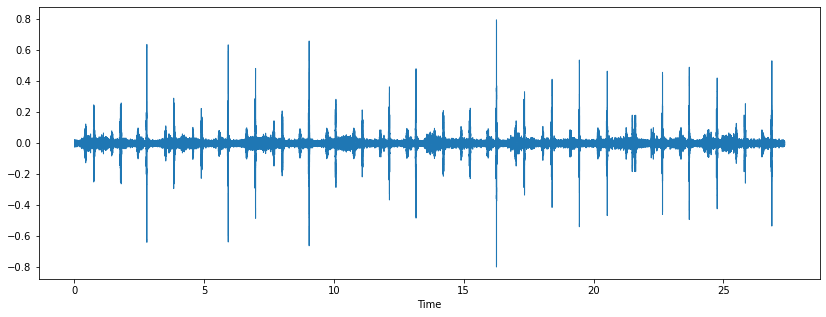

In [58]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

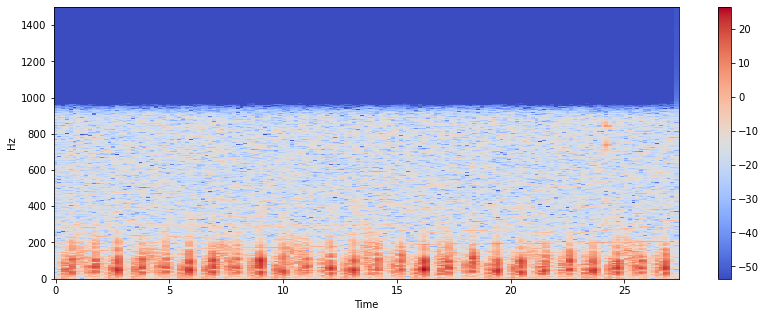

In [59]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
fig = plt.Figure()
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
fig.savefig(fig_path + '.png')

The following functions are from [here](https://stackoverflow.com/questions/56719138/how-can-i-save-a-librosa-spectrogram-plot-as-a-specific-sized-image/57204349#57204349)

In [27]:
# def scale_minmax(X, min=0.0, max=1.0):
#     X_std = (X - X.min()) / (X.max() - X.min())
#     X_scaled = X_std * (max - min) + min
#     return X_scaled

# def spectrogram_image(y, sr, out, hop_length, n_mels):
#     # use log-melspectrogram
#     mels = librosa.feature.melspectrogram(y=y, sr=sr, 
#                                           n_mels=n_mels,
#                                           n_fft=hop_length*2, 
#                                           hop_length=hop_length)
    
#     mels = np.log(mels + 1e-9) # add small number to avoid log(0)

#     # min-max scale to fit inside 8-bit range
#     img = scale_minmax(mels, 0, 255).astype(np.uint8)
#     img = np.flip(img, axis=0) # put low frequencies at the bottom in image
#     img = 255-img # invert. make black==more energy

#     # save as PNG
#     skimage.io.imsave(out, img)

The next code is from [here](https://stackoverflow.com/questions/60255152/how-can-i-convert-spectrogram-data-to-a-tensor-or-multidimensional-numpy-array)

In [46]:
# import wave
# with wave.open(audio_file, "rb") as wave_file:
#     sr = wave_file.getframerate()
# print(sr)

# audio_binary = tf.read_file(audio_file)

# # tf.contrib.ffmpeg not supported on Windows, refer to issue
# # https://github.com/tensorflow/tensorflow/issues/8271
# waveform = tf.contrib.ffmpeg.decode_audio(audio_binary, file_format='wav', samples_per_second=sr, channel_count=1)
# print(waveform.numpy().shape)

# signals = tf.reshape(waveform, [1, -1])
# signals.get_shape()

# # Compute a [batch_size, ?, 128] tensor of fixed length, overlapping windows
# # where each window overlaps the previous by 75% (frame_length - frame_step
# # samples of overlap).
# frames = tf.contrib.signal.frame(signals, frame_length=128, frame_step=32)
# print(frames.numpy().shape)

# # `magnitude_spectrograms` is a [batch_size, ?, 129] tensor of spectrograms. We
# # would like to produce overlapping fixed-size spectrogram patches; for example,
# # for use in a situation where a fixed size input is needed.
# magnitude_spectrograms = tf.abs(tf.contrib.signal.stft(
#     signals, frame_length=256, frame_step=64, fft_length=256))

# print(magnitude_spectrograms.numpy().shape)